# Защита данных клиентов

### Цель проекта:

Защитить данные так, чтобы после их изменения качество ML модели осталось прежним. Наилучшую модель при этом подбирать не нужно.


### Шаги выполнения проекта:

1. Предобработка данных.
2. Работа с матрицами.
3. Выбор алгоритма преобразования.
4. Тестирование алгоритма.


## 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.spatial import distance

In [3]:
ins = pd.read_csv('/datasets/insurance.csv')
ins

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [4]:
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Колонка "Возраст" имеет тип float. Посмотрим, есть ли там вещественные числа:

In [5]:
ins['Возраст'].unique()

array([41., 46., 29., 21., 28., 43., 39., 25., 36., 32., 38., 23., 40.,
       34., 26., 42., 27., 33., 47., 30., 19., 31., 22., 20., 24., 18.,
       37., 48., 45., 44., 52., 49., 35., 56., 65., 55., 57., 54., 50.,
       53., 51., 58., 59., 60., 61., 62.])

Все значения целые. Изменим тип столбца:

In [6]:
ins['Возраст'] = ins['Возраст'].astype(int)
ins['Возраст'].dtype

dtype('int64')

In [7]:
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null int64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


Теперь посмотрим на наличие дубликатов:

In [8]:
ins.duplicated().sum()

153

In [9]:
ins[ins.duplicated() == True]

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
281,1,39,48100.0,1,0
488,1,24,32900.0,1,0
513,0,31,37400.0,2,0
718,1,22,32600.0,1,0
785,0,20,35800.0,0,0
...,...,...,...,...,...
4793,1,24,37800.0,0,0
4902,1,35,38700.0,1,0
4935,1,19,32700.0,0,0
4945,1,21,45800.0,0,0


Удалим дубликаты:

In [10]:
ins = ins.drop_duplicates().reset_index(drop = True)
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
Пол                  4847 non-null int64
Возраст              4847 non-null int64
Зарплата             4847 non-null float64
Члены семьи          4847 non-null int64
Страховые выплаты    4847 non-null int64
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


Проверим наличие пропусков:

In [11]:
ins.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

Пропущенных значений нет.  
Посмотрим, какие уникальные значения есть в столбце "Страховые выплаты":

In [12]:
ins['Страховые выплаты'].unique()

array([0, 1, 2, 3, 5, 4])

Получается, у нас будет 6 количественных показателей: от 0 (клиенты, не получившие страховую выплату ни разу за 5 лет) и до 5 (клиенты, получившие выплату 5 раз за 5 лет (предположительно по 1 разу в год)). Используем регрессионные модели.  
Тем не менее, нельзя не отметить тот факт, что эту шкалу можно перевести в номинальную, тогда бы у нас получилось 6 качественных признаков. 

Данные предобработаны. Переходим ко второму шагу:

## 2. Работа с матрицами

В целях защиты данных создадим рандомную обратимую матрицу, на которую будем умножать признаки:

In [13]:
nrows = 4

ncols = 4

rand_matrix = np.random.randint(1, 100, size=(nrows,ncols))

rand_matrix

array([[71, 58,  8, 13],
       [91, 60, 84, 17],
       [98, 49, 89, 95],
       [60,  4,  4,  1]])

Далее обучим линейную регрессию до умножения на обратимую матрицу. Однако чтобы в случае неизменения качества модели указать связь параметров линейной регрессии в исходной задаче и в преобразованной, создадим класс LinearRegression:

In [14]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        self.w = self.w
        return test_features.dot(self.w) + self.w0

In [15]:
features = ins.drop('Страховые выплаты', axis=1)
target = ins['Страховые выплаты']

In [16]:
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print(r2_score(target, predictions).round(10))

0.4302010045


Достаточно низкий показатель, однако подбор наилучшей модели не является целью данного проекта.  

В таком случае умножим данные:

In [17]:
new_features = features.dot(rand_matrix)
new_features

,0,1,2,3
0,4864662.0,2432922.0,4417856.0,4712711.0
1,3728246.0,1864764.0,3385868.0,3610783.0
2,2060639.0,1030740.0,1871436.0,1995493.0
3,4088631.0,2044568.0,3713072.0,3961859.0
4,2560419.0,1280638.0,2325260.0,2479989.0
...,...,...,...,...
4842,3501268.0,1750988.0,3179660.0,3391978.0
4843,5138354.0,2569644.0,4666460.0,4978579.0
4844,3324140.0,1662308.0,3018788.0,3220842.0
4845,3206853.0,1603690.0,2912168.0,3106890.0


Признаки умножены. Определим качество модели, обучив ее и вычислив коэффициент детерминации:

In [18]:
new_model = LinearRegression()
new_model.fit(new_features, target)
predictions_new = new_model.predict(new_features)
print(r2_score(target, predictions_new).round(10))

0.4302010045


Метрика R2 не изменилась. Таким образом, после преобразования данных качество модели не меняется.

Обоснуем, почему это происходит (поскольку сами признаки после преобразования имеют другие значения).

В целях обоснования "вытащим" из класса значения w и w0, написав функцию:

In [19]:
def fit_rationale(train_features, train_target):
    X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
    y = train_target
    w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    w = w[1:]
    w0 = w[0]
    return w, w0

In [20]:
model_before = fit_rationale(features, target)
model_before

(array([ 9.46018141e-03,  3.61640081e-02, -1.38991363e-07, -1.42517371e-02]),
 0.009460181409270258)

In [21]:
model_after = fit_rationale(new_features, target)
model_after

(array([-0.00029699,  0.00055333,  0.00043532, -0.00038686]),
 -0.0002969912351094609)

Как мы видим, значения разнятся. Построим плот и посмотрим на разброс данных наших векторов w:

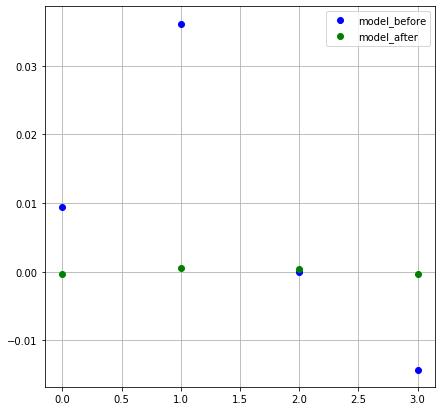

In [22]:
plt.figure(figsize=(7, 7))
# plt.axis([-0.01, 1.01, -0.01, 0.1])
plt.plot(model_before[0], 'ro', color='b', label='model_before')
plt.plot(model_after[0], 'ro', color='g', label='model_after')
plt.legend()
plt.grid(True)
plt.show()

Разброс весьма существенен, однако после изменения значений признаков (умножения их на обратимую матрицу), наши показатели больше стремятся к нулю по оси y, нежели чем до этого. Можно предположить, что подобное изменение признаков в некой мере послужило масштабированием признаков, поскольку в изначальной выборке признаки разнятся и имеют довольно сильный разброс. Так, например, количество членов семьи варьируется от 0 до 6, в то время как зарплата исчисляется детясками (или сотнями) тысяч. Таким образом, признак "Зарплата" как бы "перетягивает" на себя значимость при обучении модели. В случае умножения на матрицу такие моменты несколько сглаживаются.

Теперь нарисуем векторы:

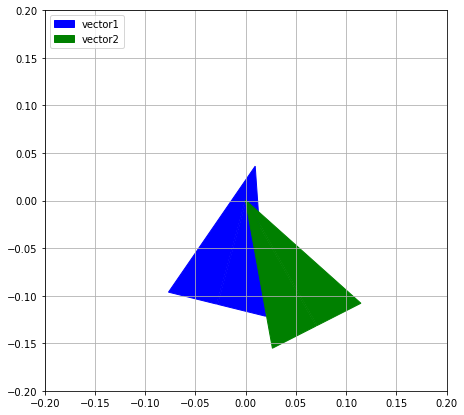

In [23]:
vector1 = model_before[0]
vector2 = model_after[0]

plt.figure(figsize=(7.2, 7))
plt.axis([-0.2, 0.2, -0.2, 0.2])
arrow1 = plt.arrow(0, 0, vector1[0], vector1[1],
               head_width=0.1, length_includes_head="True", color='b')
arrow2 = plt.arrow(0, 0, vector2[0], vector2[1],
               head_width=0.1, length_includes_head="True", color='g')
plt.plot()
plt.legend([arrow1, arrow2], ['vector1', 'vector2'], loc='upper left')
plt.grid(True)
plt.show()

Исходя из графика можно сказать, что векторы имеют одинаковый характер. Не смотря на то, что направлены они могут быть в разные стороны (в зависимости от рандомно подобранных значений матрицы), однако размер векторов один, что наталкивает на мысль о том, что данные после умножения не были "утеряны". Они лишь были преобразованы, заняв другие точки пространства. В таком случае можно сказать, что смена координат на обучение модели и конкретно на качество предсказания никак не повлияла, о чем и свидетельствует идентичный коэффициент детерминации что до умножения признаков на матрицу, что после умножения.

Вместе с тем, удостоверимся в правильности вывода: умножим признаки на обратную матрицу и проверим, выведутся ли исходные цифры признаков:

In [24]:
new_features.dot(np.linalg.inv(rand_matrix)).round()

,0,1,2,3
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,-0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,-0.0
...,...,...,...,...
4842,0.0,28.0,35700.0,2.0
4843,0.0,34.0,52400.0,1.0
4844,0.0,20.0,33900.0,2.0
4845,1.0,22.0,32700.0,3.0


In [25]:
features

,Пол,Возраст,Зарплата,Члены семьи
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4842,0,28,35700.0,2
4843,0,34,52400.0,1
4844,0,20,33900.0,2
4845,1,22,32700.0,3


Значения признаков идентичны.  
Таким образом, мы удостоверились, что умножение на обратимую матрицу (вне зависимости от значений, которые в ней представлены, кроме нуля) не изменяет значения признаков, а лишь преобразовывает их, определяя для вектора w и величины w0 другие точки пространства. Соответственно, умножая признаки на матрицу, мы просто делаем сдвиг, не меняя взаимосвязей внутри модели. Качество модели при этом остается на том же уровне.

## 3. Выбор алгоритма преобразования

**Алгоритм**

В целях защиты персональных данных клиентов страховой компании нам необходимо применить такой метод преобразования данных, при котором мы могли бы восстановить персональную информацию, в то же время посторонним это сделать было бы сложно.
В таком случае, можно применить умножение признаков на обратимую матрицу.

**Обоснование**

Как уже было сказано в пункте 2, умножение на обратимую матрицу хорошо защищает данные, образуя "новые" значения, и в то же время качество модели до умножения признаков на матрицу и после не меняется. Перепроверим эту информацию на шаге 4:

## 4. Тестирование алгоритма

Cгенерируем матрицу 4х4 с числами из непрерывного равномерного распределения:

In [26]:
new_matrix = np.random.rand(4,4)
new_matrix

array([[0.02952829, 0.35252093, 0.48242806, 0.92023842],
       [0.23883916, 0.61034266, 0.25229387, 0.38774455],
       [0.71334997, 0.19503769, 0.51739581, 0.60203106],
       [0.88201128, 0.55884426, 0.13765334, 0.29758073]])

Умножим наши признаки на матрицу:

In [27]:
new_features_2 = features.dot(new_matrix)
new_features_2

,0,1,2,3
0,35392.862413,9699.804853,25673.796330,29877.856046
1,27119.167439,7440.066838,19672.783970,22895.314205
2,14987.275687,4113.491433,10872.628542,12653.896905
3,29753.473356,8147.006569,21580.978775,25113.433104
4,18625.151218,5107.925832,13511.577310,15724.787817
...,...,...,...,...
4842,25475.045416,6981.052826,18478.369969,21503.960941
4843,37388.540924,10241.285466,27120.256114,31559.908571
4844,24189.104758,6625.102242,17545.039159,20417.203072
4845,23334.474013,6393.189065,16925.288856,19696.759105


Теперь обучим модель, вызвав класс LinearRegression:

In [28]:
model_step_4 = LinearRegression()
model_step_4.fit(new_features_2, target)
predictions_step_4 = model_step_4.predict(new_features_2)
print(r2_score(target, predictions_step_4).round(10))

0.4302010045


Вспомним значение r2 до преобразования признаков:

In [29]:
r2_score(target, predictions).round(10)

0.4302010045

Как и следовало ожидать, качество модели не изменилось, и данные клиентов успешно зашифрованы.

### Вывод

Целью работы являлась защита данных клиентов компании. Необходимо было разработать метод преобразования данных, после внедрения которого было бы сложно восстановить персональную информацию.  
Работа делилась на несколько шагов:  
На первом шаге мы предобработали данные и удалили дубликаты.  
Вторым шагом было умножение признаков на обратимую матрицу, а также ответ на вопрос: изменится ли качество линейной регрессии? По итогам анализа можно сказать, что качество модели не изменяется.  
Также мы выявили связь параметров линейной регрессии в исходной задаче и в преобразованной.  
Третьим шагом стал выбор алгоритма защиты данных пользователей. Закономерно в качестве алгоритма было выбрано умножение признаков на сгенерированную случайным образом обратимую матрицу с числами из непрерывного равномерного распределения.  
Завершающим, четвертым, шагом было непосредственно генерирование матрицы, умножение признаков на нее и последующее обучение модели линейной регрессии. По итогам обучения и последующего предсказания модели вычислен коэффициент детерминации, который остался без изменений. Соответственно, можно утверждать, что качество модели не изменилось.